# Mercari Price Suggestion Challenge GBM Classifier using full data

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pdb
import re
import pickle
import string
import pandas as pd
import numpy as np
import scipy
import lightgbm as lgb
np.set_printoptions(precision=4)

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
from args import args
vars(args)

{'path': PosixPath('data'),
 'workdir': PosixPath('data/workdir'),
 'train_tsv': PosixPath('data/train.tsv'),
 'test_tsv': PosixPath('data/test.tsv'),
 'test2_tsv': PosixPath('data/test_stg2.tsv'),
 'modeldir': PosixPath('data/workdir/models'),
 'vectordir': PosixPath('data/workdir/vectordir'),
 'figdir': PosixPath('data/figures')}

## Functions

In [ ]:
def test(a,b,cmp,cname=None):
  if cname is None: cname=cmp.__name__
  assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def near(a,b): return np.allclose(a, b, rtol=1e-1, atol=1e-1)
def test_near(a,b): test(a,b,near)
  
def set_two_splits(df, name, pct=0.15, seed=None):
  df['split'] = 'train'
  _, val_idxs = train_test_split(np.arange(len(df)), test_size=pct, random_state=seed)
  df.loc[val_idxs, 'split'] = name

  test_near(round(len(df[df['split'] == 'train'])/len(df), 2), 1-pct)
  test_near(round(len(df[df['split'] == name])/len(df), 2), pct)

  return df

## Train and Validation

In [ ]:
data_df = pd.read_csv(args.path/'train_df.csv', usecols=['item_condition_id', 'brand_name', 'shipping', 'main_cat', 'sub_cat1', 'sub_cat2', 'text', 'price'])
data_df.head()

In [ ]:
seed = 643
df = set_two_splits(data_df.copy(), 'valid', seed=seed)
train_df = df.loc[df['split'] == 'train'].copy()
valid_df = df.loc[df['split'] == 'valid'].copy()
y_train = train_df['price']
y_valid = valid_df['price']

df.shape, train_df.shape, valid_df.shape, y_train.shape, y_valid.shape

### Preprocessing

`item_condition_id` has no `NaN` in all the datasets, so I'm just going to leave it alone.

Brands and categories are encoded as a function of mean price. Basically, we group the brands by price, compute the mean, assign ids to it with lowest id going to the brand with the highest mean price. Then ids are normalized by dividing them with the number of brands and these values are assigned as the brand value.

In [ ]:
brands = train_df.groupby('brand_name')['price'].mean().sort_values(ascending=False).to_frame()
brands['id'] = brands.reset_index().index.values
brand_names = brands.index.values

train_brand_data = brands.loc[train_df['brand_name']]
train_df.loc[:, 'brand_val'] = train_brand_data['id'].values/len(brand_names)

valid_brand_data = brands.loc[valid_df['brand_name']]
valid_df.loc[:, 'brand_val'] = valid_brand_data['id'].values/len(brand_names)

maincats = train_df.groupby('main_cat')['price'].mean().sort_values(ascending=False).to_frame()
maincats['id'] = maincats.reset_index().index.values
maincat_names = maincats.index.values

train_maincats = maincats.loc[train_df['main_cat']]
train_df.loc[:, 'maincat_val'] = train_maincats['id'].values/len(maincat_names)

valid_maincats = maincats.loc[valid_df['main_cat']]
valid_df.loc[:, 'maincat_val'] = valid_maincats['id'].values/len(maincat_names)

subcat1s = train_df.groupby('sub_cat1')['price'].mean().sort_values(ascending=False).to_frame()
subcat1s['id'] = subcat1s.reset_index().index.values
subcat1_names = subcat1s.index.values

train_subcat1s = subcat1s.loc[train_df['sub_cat1']]
train_df.loc[:, 'subcat1_val'] = train_subcat1s['id'].values/len(subcat1_names)

valid_subcat1s = subcat1s.loc[valid_df['sub_cat1']]
valid_df.loc[:, 'subcat1_val'] = valid_subcat1s['id'].values/len(subcat1_names)

subcat2s = train_df.groupby('sub_cat2')['price'].mean().sort_values(ascending=False).to_frame()
subcat2s['id'] = subcat2s.reset_index().index.values
subcat2_names = subcat2s.index.values

train_subcat2s = subcat2s.loc[train_df['sub_cat2']]
train_df.loc[:, 'subcat2_val'] = train_subcat2s['id'].values/len(subcat2_names)

valid_subcat2s = subcat2s.loc[valid_df['sub_cat2']]
valid_df.loc[:, 'subcat2_val'] = valid_subcat2s['id'].values/len(subcat2_names)

Now we have to extract all the `_val`s as a separate matrix so that it can be combined with the tfidf vector

In [ ]:
train_str_val = train_df[['item_condition_id', 'shipping', 'brand_val', 'maincat_val', 'subcat1_val', 'subcat2_val']].values

valid_str_val = valid_df[['item_condition_id', 'shipping', 'brand_val', 'maincat_val', 'subcat1_val', 'subcat2_val']].values

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
train_desc_val = vectorizer.fit_transform(train_df['text'].values.astype('U'))
valid_desc_val = vectorizer.transform(valid_df['text'].values.astype('U'))

x_train = scipy.sparse.hstack((train_str_val, train_desc_val)).tocsr()
y_train = train_df['price']

x_valid = scipy.sparse.hstack((valid_str_val, valid_desc_val)).tocsr()
y_valid = valid_df['price']

idx2tok = {v: k for k, v in vectorizer.vocabulary_.items()}

Make sure all the values are correctly reprsented where they need to be

In [ ]:
train_df.head()

In [ ]:
train_str_val[:10]

In [ ]:
scipy.sparse.csr_matrix.todense(x_train[:10, :6])

In [ ]:
valid_df.head()

In [ ]:
valid_str_val[:10]

In [ ]:
scipy.sparse.csr_matrix.todense(x_valid[:10, :6])

### Training

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

lgb_params = {
  'num_leaves': 400,
  'learning_rate': 0.05,
  'feature_fraction': 0.9,
  'bagging_fraction': 0.7,
  'bagging_freq': 5,
  'metric': 'rmse',
  'num_threads': 32,
  'max_bin': 32,
  'objective': 'regression',
}

In [ ]:
fn = ['item_condition_id', 'shipping', 'brand_name', 'main_cat', 'sub_cat1', 'sub_cat2'] + [f'token_{i}' for i in range(len(vectorizer.vocabulary_))]

In [ ]:
evals_result = {} 

gbm = lgb.train(lgb_params, lgb_train, num_boost_round=10, feature_name=fn, valid_sets=[lgb_train, lgb_valid], evals_result=evals_result, early_stopping_rounds=10, verbose_eval=True)

fig, ax = plt.subplots(figsize=(11, 8))
lgb.plot_metric(evals_result, ax=ax, metric='rmse')

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 20))
# d, wc = wordcloud(gbm.feature_importance(importance_type='gain'), idx2tok, min_len=5, n_tokens=500)
# ax.imshow(wc)
# ax.axis('off')
# fig.savefig(args.figdir/'desc_wc.pdf', dpi=300)

In [ ]:
preds = gbm.predict(x_valid)
np.round(np.sqrt(mean_squared_error(y_valid, preds)), 3)

In [ ]:
fi = gbm.feature_importance(importance_type='gain')

idxs = np.argsort(fi)[-15:]

features = []
for i in idxs:
  feature = fn[i]
  if 'token_' not in feature:
    features.append(fn[i])
  else:
    features.append(idx2tok[int(feature[6:])])

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
lgb.plot_importance(gbm, max_num_features=15, ax=ax, importance_type='gain', precision=2)
ax.set_yticklabels(features);

## Full Model Training

In [ ]:
train_df = pd.read_csv(args.path/'train_df.csv', usecols=['item_condition_id', 'brand_name', 'shipping', 'main_cat', 'sub_cat1', 'sub_cat2', 'text', 'price'])
train_df.head()

In [ ]:
brands = train_df.groupby('brand_name')['price'].mean().sort_values(ascending=False).to_frame()
brands['id'] = brands.reset_index().index.values
brand_names = brands.index.values

train_brand_data = brands.loc[train_df['brand_name']]
train_df.loc[:, 'brand_val'] = train_brand_data['id'].values/len(brand_names)

maincats = train_df.groupby('main_cat')['price'].mean().sort_values(ascending=False).to_frame()
maincats['id'] = maincats.reset_index().index.values
maincat_names = maincats.index.values

train_maincats = maincats.loc[train_df['main_cat']]
train_df.loc[:, 'maincat_val'] = train_maincats['id'].values/len(maincat_names)

subcat1s = train_df.groupby('sub_cat1')['price'].mean().sort_values(ascending=False).to_frame()
subcat1s['id'] = subcat1s.reset_index().index.values
subcat1_names = subcat1s.index.values

train_subcat1s = subcat1s.loc[train_df['sub_cat1']]
train_df.loc[:, 'subcat1_val'] = train_subcat1s['id'].values/len(subcat1_names)

subcat2s = train_df.groupby('sub_cat2')['price'].mean().sort_values(ascending=False).to_frame()
subcat2s['id'] = subcat2s.reset_index().index.values
subcat2_names = subcat2s.index.values

train_subcat2s = subcat2s.loc[train_df['sub_cat2']]
train_df.loc[:, 'subcat2_val'] = train_subcat2s['id'].values/len(subcat2_names)

In [ ]:
train_str_val = train_df[['item_condition_id', 'shipping', 'brand_val', 'maincat_val', 'subcat1_val', 'subcat2_val']].values

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
train_desc_val = vectorizer.fit_transform(train_df['text'].values.astype('U'))

x_train = scipy.sparse.hstack((train_str_val, train_desc_val)).tocsr()
y_train = train_df['price']

idx2tok = {v: k for k, v in vectorizer.vocabulary_.items()}

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_params = {
  'num_leaves': 400,
  'learning_rate': 0.05,
  'feature_fraction': 0.9,
  'bagging_fraction': 0.7,
  'bagging_freq': 5,
  'metric': 'rmse',
  'num_threads': 32,
  'max_bin': 32,
  'objective': 'regression',
}

In [ ]:
fn = ['item_condition_id', 'shipping', 'brand_name', 'main_cat', 'sub_cat1', 'sub_cat2'] + [f'token_{i}' for i in range(len(vectorizer.vocabulary_))]
evals_result = {} 
gbm = lgb.train(lgb_params, lgb_train, num_boost_round=1000, feature_name=fn, valid_sets=[lgb_train], evals_result=evals_result, early_stopping_rounds=10, verbose_eval=True)
pickle.dump(gbm, (args.modeldir/f'gbm_full_all.pkl').open('wb'))

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
lgb.plot_metric(evals_result, ax=ax, metric='rmse')
ax.set_xlabel('# Iterations')
ax.set_ylabel('Root Mean Square Log Error')
ax.set_title('')
ax.legend('')
fig.savefig(args.figdir/'train_loss.pdf', dpi=300)

## Feature Importance

In [25]:
gbm = pickle.load((args.modeldir/'gbm_full_all.pkl').open('rb'))

with open(args.vectordir/'default_bi_all.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  _ = pickle.load(f)

idx2tok = {v: k for k, v in vectorizer.vocabulary_.items()}

fn = ['item_condition_id', 'shipping', 'brand_name', 'main_cat', 'sub_cat1', 'sub_cat2'] + [f'token_{i}' for i in range(len(vectorizer.vocabulary_))]

In [34]:
n_features=20

fi = gbm.feature_importance(importance_type='gain')
idxs = np.argsort(fi)

p = re.compile('^[a-z\s]+$')
features = []
fidxs = []
for i in idxs:
  feature = fn[i]
  if 'token_' not in feature:
    features.append(fn[i])
    fidxs.append(i)
#   else:    
#       token = idx2tok[int(feature[6:])]
#       tokens = token.split()
#       re_token = []
#       for t in tokens:
#         if len(t) > 5 and p.match(t):
#           re_token.append(t)
          
#       if len(re_token) > 0:
#         features.append(' '.join(re_token))
#         fidxs.append(i)

fidxs = np.array(fidxs)        
fi = fi[fidxs]
fi = fi/fi.max()

In [35]:
fi_df = pd.DataFrame({'feature': features, 'importance': fi}).sort_values('importance', ascending=False).reset_index(drop=True)
plot_df = fi_df.head(n_features)

In [31]:
plot_df.loc[:, 'feature'] = plot_df['feature'].copy().apply(lambda x: x + '*' if '_' not in x else x)

In [36]:
plot_df.tail(10)

,feature,importance
0,brand_name,1.000000
1,sub_cat2,0.568891
2,shipping,0.123259
3,item_condition_id,0.093820
4,sub_cat1,0.066798
5,main_cat,0.031748


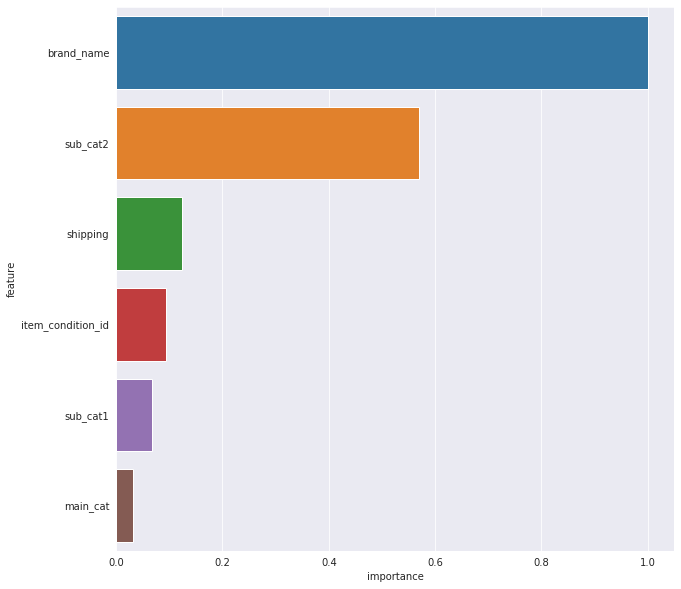

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=plot_df, ci=None)
fig.savefig(args.figdir/'fi_full.pdf', dpi=300)

## Testing on test sets

In [10]:
gbm = pickle.load((args.modeldir/'gbm_full_all.pkl').open('rb'))

with open(args.vectordir/'default_bi_all.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  _ = pickle.load(f)

idx2tok = {v: k for k, v in vectorizer.vocabulary_.items()}

In [11]:
with open(args.path/'cat_vars.pkl', 'rb') as f:
  brands = pickle.load(f)
  maincats = pickle.load(f)
  subcat1s = pickle.load(f)
  subcat2s = pickle.load(f)
  
brand_names = brands.index.values
maincat_names = maincats.index.values
subcat1_names = subcat1s.index.values
subcat2_names = subcat2s.index.values

### Test Dataset

In [12]:
test_df = pd.read_csv(args.path/'test_df.csv', usecols=['test_id', 'item_condition_id', 'brand_name', 'shipping', 'main_cat', 'sub_cat1', 'sub_cat2', 'text'])

test_df['brand_name'] = test_df['brand_name'].apply(lambda name: name if name in brand_names else 'missing')
test_brand_data = brands.loc[test_df['brand_name']]
test_df.loc[:, 'brand_val'] = test_brand_data['id'].values/len(brand_names)

test_df['main_cat'] = test_df['main_cat'].apply(lambda name: name if name in maincat_names else 'missing')
test_maincats = maincats.loc[test_df['main_cat']]
test_df.loc[:, 'maincat_val'] = test_maincats['id'].values/len(maincat_names)

test_df['sub_cat1'] = test_df['sub_cat1'].apply(lambda name: name if name in subcat1_names else 'missing')
test_subcat1s = subcat1s.loc[test_df['sub_cat1']]
test_df.loc[:, 'subcat1_val'] = test_subcat1s['id'].values/len(subcat1_names)

test_df['sub_cat2'] = test_df['sub_cat2'].apply(lambda name: name if name in subcat2_names else 'missing')
test_subcat2s = subcat2s.loc[test_df['sub_cat2']]
test_df.loc[:, 'subcat2_val'] = test_subcat2s['id'].values/len(subcat2_names)

In [13]:
test_str_val = test_df[['item_condition_id', 'shipping', 'brand_val', 'maincat_val', 'subcat1_val', 'subcat2_val']].values
test_desc_val = vectorizer.transform(test_df['text'].values.astype('U'))
x_test = scipy.sparse.hstack((test_str_val, test_desc_val)).tocsr()

In [14]:
preds = pd.DataFrame({'test_id': test_df['test_id'], 'price': np.expm1(gbm.predict(x_test))})
preds.to_csv(args.path/'gbm_full_submission.csv', index=False)

### Test_stg2 Dataset

In [15]:
test2_df = pd.read_csv(args.path/'test2_df.csv', usecols=['test_id', 'item_condition_id', 'brand_name', 'shipping', 'main_cat', 'sub_cat1', 'sub_cat2', 'text'])

test2_df['brand_name'] = test2_df['brand_name'].apply(lambda name: name if name in brand_names else 'missing')
test2_brand_data = brands.loc[test2_df['brand_name']]
test2_df.loc[:, 'brand_val'] = test2_brand_data['id'].values/len(brand_names)

test2_df['main_cat'] = test2_df['main_cat'].apply(lambda name: name if name in maincat_names else 'missing')
test2_maincats = maincats.loc[test2_df['main_cat']]
test2_df.loc[:, 'maincat_val'] = test2_maincats['id'].values/len(maincat_names)

test2_df['sub_cat1'] = test2_df['sub_cat1'].apply(lambda name: name if name in subcat1_names else 'missing')
test2_subcat1s = subcat1s.loc[test2_df['sub_cat1']]
test2_df.loc[:, 'subcat1_val'] = test2_subcat1s['id'].values/len(subcat1_names)

test2_df['sub_cat2'] = test2_df['sub_cat2'].apply(lambda name: name if name in subcat2_names else 'missing')
test2_subcat2s = subcat2s.loc[test2_df['sub_cat2']]
test2_df.loc[:, 'subcat2_val'] = test2_subcat2s['id'].values/len(subcat2_names)

In [16]:
test2_str_val = test2_df[['item_condition_id', 'shipping', 'brand_val', 'maincat_val', 'subcat1_val', 'subcat2_val']].values
test2_desc_val = vectorizer.transform(test2_df['text'].values.astype('U'))
x_test = scipy.sparse.hstack((test2_str_val, test2_desc_val)).tocsr()

In [17]:
preds = pd.DataFrame({'test_id': test2_df['test_id'], 'price': np.expm1(gbm.predict(x_test))})
preds.to_csv(args.path/'gbm_full_submission_stg2.csv', index=False)